In [1]:
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D,GlobalAveragePooling2D

from tensorflow.keras.layers import Lambda, Flatten, Dense

from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL


import tensorflow.keras
from keras_vggface.vggface import VGGFace

from keras_vggface import utils
import deepface
from deepface import DeepFace
import cv2

%matplotlib inline

In [2]:

from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D,GlobalAveragePooling2D

from tensorflow.keras.layers import Lambda, Flatten, Dense

from tensorflow.keras.layers import Layer
from keras.optimizers import Adam


import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL

import tensorflow.keras
from keras_vggface.vggface import VGGFace

from keras_vggface import utils
import deepface
from deepface import DeepFace
import cv2

from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline


In [118]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [3]:
from keras.applications import VGG19

In [4]:
from keras.applications.vgg19 import preprocess_input

In [5]:
vgg= VGG19(weights='imagenet',include_top=False,input_shape=[126,126,3])

In [6]:

import random
import shutil

In [7]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 126, 126, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 126, 126, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 126, 126, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 63, 63, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 63, 63, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 63, 63, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 31, 31, 128)       0     

In [61]:
def model():
    x=vgg.output
    #x=Conv2D(filters=32,kernel_size=2,strides=1,padding='valid')(x)
    #x=MaxPooling2D(pool_size=2,strides=1)(x)
    x=Flatten()(x)
    x=tf.keras.layers.Dropout(0.3)(x)
    x=Dense(2,activation='sigmoid')(x)
    
    model=Model(inputs=vgg.input,outputs=x)
    return model
    
    

In [62]:
newmodel=model()

In [63]:
for layer in newmodel.layers[:-3]:
    layer.trainable = False

#train the rest of the layers - 19 onwards
for layer in newmodel.layers[-3:]:
    layer.trainable = True

In [64]:
newmodel.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 126, 126, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 126, 126, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 126, 126, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 63, 63, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 63, 63, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 63, 63, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 31, 31, 128)       0   

In [65]:
newmodel.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [66]:
from keras.preprocessing.image import ImageDataGenerator

In [67]:
train_path='archive/train'
test_path='archive/test'

def get_image_paths(directory):
    image_paths=[]
    for root, dirs,files in os.walk(directory):
        for file in files:
            if(file.endwith(".jpg",".jpeg",".png")):
                image=os.path.join(root.file)
                image_paths.append(image)
    return random.shuffle(image_paths)
            

def img_to_array(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(126, 126))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    return x_train

# convert the below markdown into code if u have not already created subset of train/test dataset



def create_subset_directory(original_dir, subset_dir, num_images):
    
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)

    
    image_files = [f for f in os.listdir(original_dir) if os.path.isfile(os.path.join(original_dir, f))]

    
    selected_images = random.sample(image_files, num_images)

    
    for image_file in selected_images:
        src_path = os.path.join(original_dir, image_file)
        dst_path = os.path.join(subset_dir, image_file)
        shutil.copyfile(src_path, dst_path)


original_directory= ['archive/train/REAL','archive/train/FAKE','archive/test/REAL','archive/test/FAKE']

subset_directory= ['archive/train_subset/REAL','archive/train_subset/FAKE','archive/test_subset/REAL','archive/test_subset/FAKE']

num_images=[7000,3000,3000,1500]
subsets=['archive/train_subset','archive/test_subset']


for i in range(len(original_directory)):
    create_subset_directory(original_directory[i], subset_directory[i], num_images[i])


In [40]:
subsets=['archive/train_subset','archive/test_subset']

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
train_generator=ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rescale=1./255, 
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2, 
                                  shear_range=0.2, 
                                  zoom_range=0.2,  
                                  horizontal_flip=True,  
                                  fill_mode='nearest' 
                                )
test_generator=ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rescale=1./255, 
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2, 
                                  shear_range=0.2, 
                                  zoom_range=0.2,  
                                  horizontal_flip=True,  
                                  fill_mode='nearest' 
                                )

In [43]:
train=train_generator.flow_from_directory(subsets[0],target_size=(126,126),batch_size=32)
test=test_generator.flow_from_directory(subsets[1],target_size=(126,126),batch_size=32)

Found 10000 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.


In [69]:
from tensorflow.keras.callbacks import EarlyStopping

In [70]:
callback = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    mode='min', 
    verbose=1
)


In [72]:
model_history=newmodel.fit(train,verbose=2,validation_data=test,epochs=10,callbacks=[callback])


Epoch 1/10
313/313 - 1022s - loss: 0.3720 - accuracy: 0.8379 - val_loss: 0.4106 - val_accuracy: 0.8073 - 1022s/epoch - 3s/step
Epoch 2/10
313/313 - 1038s - loss: 0.3649 - accuracy: 0.8418 - val_loss: 0.3496 - val_accuracy: 0.8427 - 1038s/epoch - 3s/step
Epoch 3/10
313/313 - 1033s - loss: 0.3751 - accuracy: 0.8351 - val_loss: 0.3352 - val_accuracy: 0.8478 - 1033s/epoch - 3s/step
Epoch 4/10
313/313 - 1018s - loss: 0.3533 - accuracy: 0.8412 - val_loss: 0.3369 - val_accuracy: 0.8442 - 1018s/epoch - 3s/step
Epoch 5/10
313/313 - 1004s - loss: 0.3652 - accuracy: 0.8389 - val_loss: 0.3347 - val_accuracy: 0.8547 - 1004s/epoch - 3s/step
Epoch 6/10
313/313 - 1008s - loss: 0.3562 - accuracy: 0.8442 - val_loss: 0.3479 - val_accuracy: 0.8416 - 1008s/epoch - 3s/step
Epoch 7/10
313/313 - 1009s - loss: 0.3562 - accuracy: 0.8463 - val_loss: 0.3333 - val_accuracy: 0.8596 - 1009s/epoch - 3s/step
Epoch 8/10
313/313 - 1065s - loss: 0.3621 - accuracy: 0.8407 - val_loss: 0.3726 - val_accuracy: 0.8351 - 1065s/

In [78]:
file_path = os.path.join('./', 'AIvsREAL.h5')

In [79]:
newmodel.save(file_path)

In [80]:
print(train.class_indices)

{'FAKE': 0, 'REAL': 1}


In [81]:
print(test.class_indices)

{'FAKE': 0, 'REAL': 1}


In [97]:
def prediction(image,final_model):
    
    img = np.around(np.array(image) / 255.0, decimals=12)
    x_pred = np.expand_dims(img, axis=0)
    result= np.argmax(final_model.predict(x_pred))
    if result==1:
        return 'REAL'
    else:
        return 'AI generated'

In [100]:
def get_image(image_path):
    i=tf.keras.preprocessing.image.load_img(image_path, target_size=(126, 126))
    return i
    
image_path='real1.jpg'

final_model=load_model('AIvsREAL.h5')

print(prediction(get_image(image_path),final_model))


1/1 [==============================] - 0s 224ms/step
REAL


In [101]:
print(prediction(get_image('fake1.jpeg'),final_model))

1/1 [==============================] - 0s 92ms/step
AI generated


In [104]:
print(f'Training Loss: {model_history.history["loss"][-1]}')
print(f'Validation Loss: {model_history.history["val_loss"][-1]}')
print(f'Training Accuracy: {model_history.history["accuracy"][-1]}')
print(f'Validation Accuracy: {model_history.history["val_accuracy"][-1]}')


Training Loss: 0.37904196977615356
Validation Loss: 0.32744285464286804
Training Accuracy: 0.8345999717712402
Validation Accuracy: 0.8564444184303284


In [116]:
def summarize_diagnostics(history):
    
    accuracy = history.history['accuracy']
    loss = history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']

    # Plot the metrics
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Accuracy')
    plt.plot(val_acc,label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Loss')
    plt.plot(val_loss,label='Validation Loss')
    plt.title('TLoss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

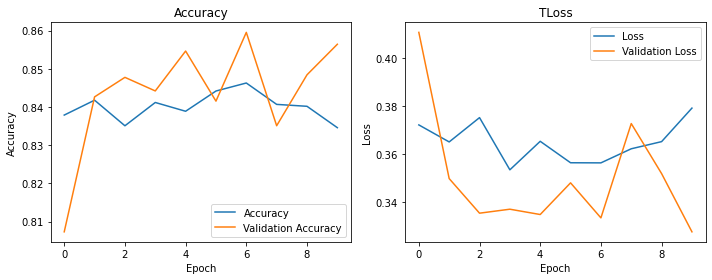

In [117]:
summarize_diagnostics(model_history)

In [120]:
y_pred = newmodel.predict_generator(test)

In [122]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test.classes

<Figure size 2880x720 with 0 Axes>

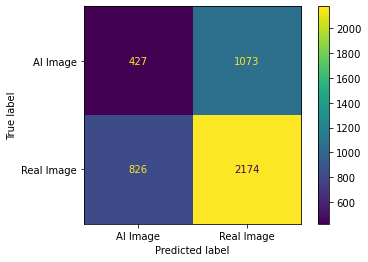

In [128]:

cm=confusion_matrix(y_true,y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=['AI Image','Real Image'])
cmd.plot()

In [1]:

def load_model():
  final_model=load_model('AIvsREAL.h5')
  return final_model


In [5]:

!pip install streamlit

  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19567 sha256=658157faedebe9463bfaee038c72e286a20ffa3f0c018062be9602bec0c3425c
  Stored in directory: c:\users\abhishek ambast\appdata\local\pip\cache\wheels\19\09\72\3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.8.1
    Uninstalling Pygments-2.8.1:
      Successfully uninstalled Pygments-2.8.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Abhishek Ambast\\anaconda3\\Lib\\site-packages\\google\\~rotobuf\\internal\\_api_implementation.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [3]:

%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_curr_model():
    with st.spinner('Model is being loaded..'):
        curr_model = load_model('AIvsREAL.h5')
    return curr_model

st.write("AI generated Images vs Real Images")

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png","jpeg"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
        size = (126,126)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    prediction = import_and_predict(image, load_curr_model())
    
    st.write(prediction)
    
    if(np.argmax(prediction)==1):
        print("This is a Real Image")
    else:
        print("This is an AI generated Image")
    
    



Overwriting app.py


In [2]:
!pip install pyngrok

  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19871 sha256=f4986e419f0aea5c44d12588335f979850ea348a1f54f2211507c513d358d4cb
  Stored in directory: c:\users\abhishek ambast\appdata\local\pip\cache\wheels\99\bb\19\229a2ca20c12e770e05a8044fa290aa80d821755ef353b0065
Successfully built pyngrok


In [3]:
!ngrok authtoken 2Rsufn2Rf4SO1iLbp698HDWU3wr_R7a9kzyVZ3PFY51z81z5

Authtoken saved to configuration file: C:\Users\Abhishek Ambast/.ngrok2/ngrok.yml


In [10]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=2d7b71ccced76dd0f976e3ec633511d45416002cdb8b86f8459dd55b8a39de7b
  Stored in directory: c:\users\abhishek ambast\appdata\local\pip\cache\wheels\bd\a8\c3\3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [10]:
!pip install unzip

  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1330 sha256=f4c01ba1fbd770cebc6d69cfaaf8476ca6136809d254ba6ecee175b4f2d241ab
  Stored in directory: c:\users\abhishek ambast\appdata\local\pip\cache\wheels\90\bd\0f\a2797a7e90de1cdd91548fba3b16a7c2560e14a268bb137101
Successfully built unzip


In [6]:
import wget

In [20]:
from pyngrok import ngrok

In [27]:
import os

In [28]:
import ssl
from pyngrok import ngrok, conf, installer

pyngrok_config = conf.get_default()

if not os.path.exists(pyngrok_config.ngrok_path):
    myssl = ssl.create_default_context();
    myssl.check_hostname=False
    myssl.verify_mode=ssl.CERT_NONE
    installer.install_ngrok(pyngrok_config.ngrok_path, context=myssl)

In [29]:
!ngrok authtoken 2Rsufn2Rf4SO1iLbp698HDWU3wr_R7a9kzyVZ3PFY51z81z

Authtoken saved to configuration file: C:\Users\Abhishek Ambast/.ngrok2/ngrok.yml


In [4]:
!nohup streamlit run app.py &

OSError: Background processes not supported.

In [33]:
from pyngrok import ngrok
url=ngrok.connect(port=8501)
url


t=2023-06-29T21:06:55+0530 lvl=eror msg="failed to auth" obj=tunnels.session err="The authtoken you specified is properly formed, but it is invalid.\nYour authtoken: 2Rsufn2Rf4SO1iLbp698HDWU3wr_R7a9kzyVZ3PFY51z81z\nThis usually happens when:\n    - You reset your authtoken\n    - Your authtoken was for a team account that you were removed from\n    - You are using ngrok link and this credential was explicitly revoked\nGo to your ngrok dashboard and double check that your authtoken is correct:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_107\r\n"
t=2023-06-29T21:06:55+0530 lvl=eror msg="failed to reconnect session" obj=csess id=92f904ed8c2e err="The authtoken you specified is properly formed, but it is invalid.\nYour authtoken: 2Rsufn2Rf4SO1iLbp698HDWU3wr_R7a9kzyVZ3PFY51z81z\nThis usually happens when:\n    - You reset your authtoken\n    - Your authtoken was for a team account that you were removed from\n    - You are using ngrok link and this credential was

PyngrokNgrokError: The ngrok process errored on start: The authtoken you specified is properly formed, but it is invalid.\nYour authtoken: 2Rsufn2Rf4SO1iLbp698HDWU3wr_R7a9kzyVZ3PFY51z81z\nThis usually happens when:\n    - You reset your authtoken\n    - Your authtoken was for a team account that you were removed from\n    - You are using ngrok link and this credential was explicitly revoked\nGo to your ngrok dashboard and double check that your authtoken is correct:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_107\r\n.

In [5]:
!st run app.py & npx localtunnel –port 8501

'st' is not recognized as an internal or external command,
operable program or batch file.
npm ERR! arg Argument starts with non-ascii dash, this is probably invalid: â€“port
npm WARN exec The following package was not found and will be installed: localtunnel@2.0.2
Usage: lt --port [num] <options>

Options:
  -p, --port                Internal HTTP server port                 [required]
  -h, --host                Upstream server providing forwarding
                                             [default: "https://localtunnel.me"]
  -s, --subdomain           Request this subdomain
  -l, --local-host          Tunnel traffic to this host instead of localhost,
                            override Host header to this host
      --local-https         Tunnel traffic to a local HTTPS server     [boolean]
      --local-cert          Path to certificate PEM file for local HTTPS server
      --local-key           Path to certificate key file for local HTTPS server
      --local-ca            Path

NameError: name 'app' is not defined

In [6]:
streamlit run app.py
npm install -g localtunnel
localtunnel --port 8501

SyntaxError: invalid syntax (<ipython-input-6-26eae9bedaae>, line 1)

In [7]:
!streamlit run app.py
!npm install -g localtunnel
localtunnel --port 8501

SyntaxError: invalid syntax (<ipython-input-7-fee2ec4a42a9>, line 3)

In [8]:
!streamlit run app.py
!npm install -g localtunnel
!localtunnel --port 8501

'streamlit' is not recognized as an internal or external command,
operable program or batch file.



added 22 packages in 425ms

3 packages are looking for funding
  run `npm fund` for details


'localtunnel' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
!git init

Initialized empty Git repository in C:/Machine_Learning/AI vs real/.git/


In [6]:
!git clone https://huggingface.co/spaces/abhishekambast/AIvsReal


Cloning into 'AIvsReal'...


In [7]:
!git add app.py

In [8]:
!git commit -m "Add application file"

[master (root-commit) 2469bc4] Add application file
 1 file changed, 46 insertions(+)
 create mode 100644 app.py


In [10]:
!git push abhishekambast/AIvsReal

fatal: The current branch master has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream abhishekambast/AIvsReal master



In [11]:
! git push main


fatal: The current branch master has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream main master



In [12]:
! git push master


fatal: The current branch master has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream master master



In [13]:
!git push


fatal: No configured push destination.
Either specify the URL from the command-line or configure a remote repository using

    git remote add <name> <url>

and then push using the remote name

    git push <name>



In [25]:
!git clone https://huggingface.co/spaces/abhishekambast/AIvsReal


fatal: destination path 'AIvsReal' already exists and is not an empty directory.


In [26]:
!git add app.py

In [27]:
!git commit -m "Add application file"

[master a091dc8] Add application file
 1 file changed, 6 insertions(+), 5 deletions(-)


In [28]:
!git push


fatal: No configured push destination.
Either specify the URL from the command-line or configure a remote repository using

    git remote add <name> <url>

and then push using the remote name

    git push <name>



In [30]:
 !git remote add app.py "https://huggingface.co/spaces/abhishekambast/AIvsReal"

In [31]:
!git push app.py

fatal: The current branch master has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream app.py master



In [32]:
!git push

fatal: No configured push destination.
Either specify the URL from the command-line or configure a remote repository using

    git remote add <name> <url>

and then push using the remote name

    git push <name>



In [9]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

SyntaxError: invalid syntax (<ipython-input-9-0bb8111d3946>, line 1)

In [12]:
import unzip
!unzip ngrok-stable-linux-amd64.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.
